In [1]:
# We begin by importing the relevant libraries. Please make sure that PyCWT is
# properly installed in your system.
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pycwt as wavelet
from pycwt.helpers import find

# My additional imports
import cmocean as cmo
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
import xarray as xr

In [2]:
SVB = xr.open_dataset('curtain_SSH_SVB_febTS.nc')
noSVB = xr.open_dataset('curtain_SSH_noSVB_febTS.nc')

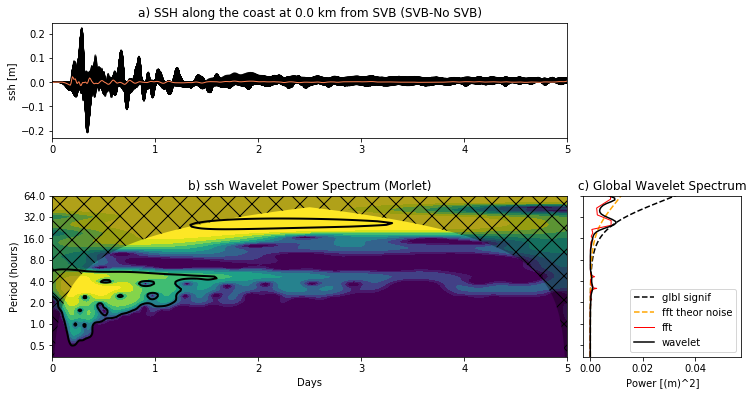

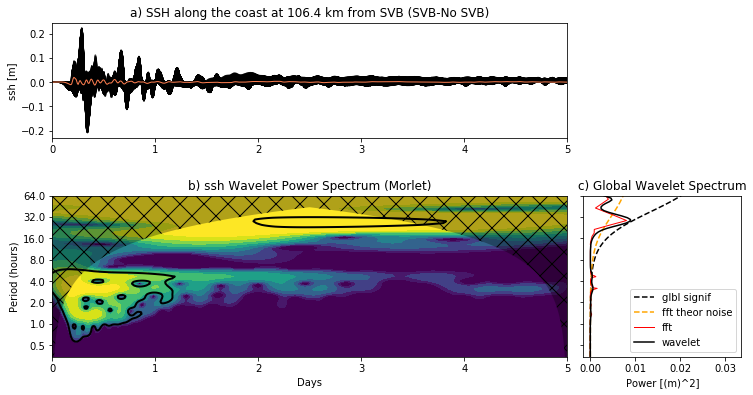

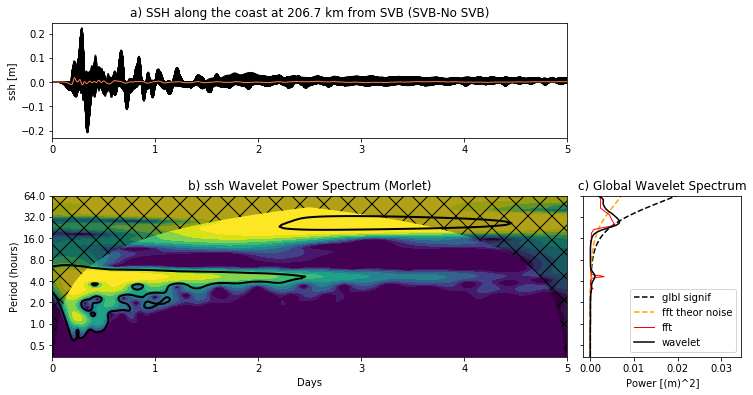

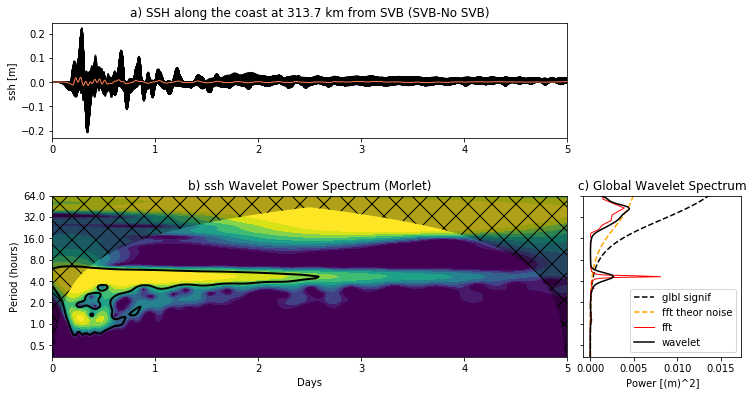

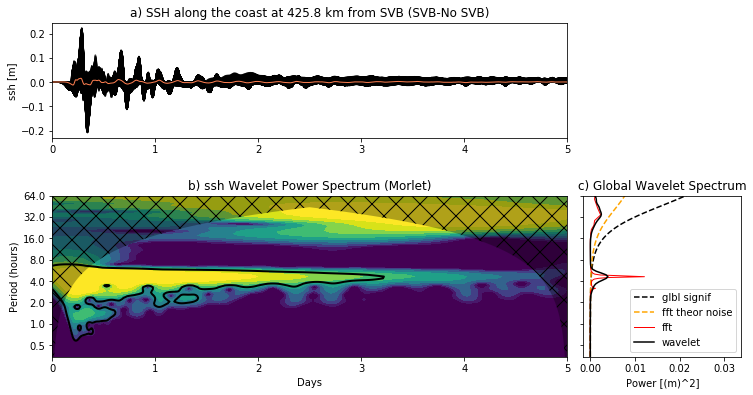

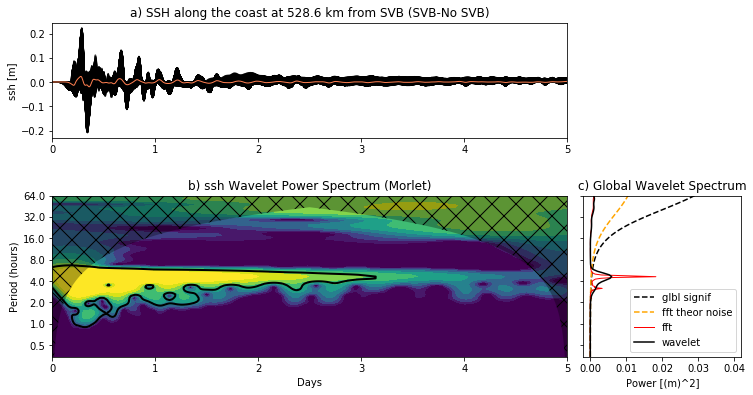

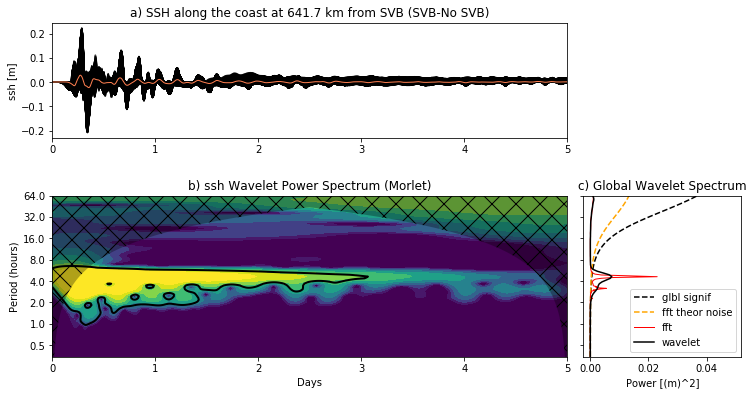

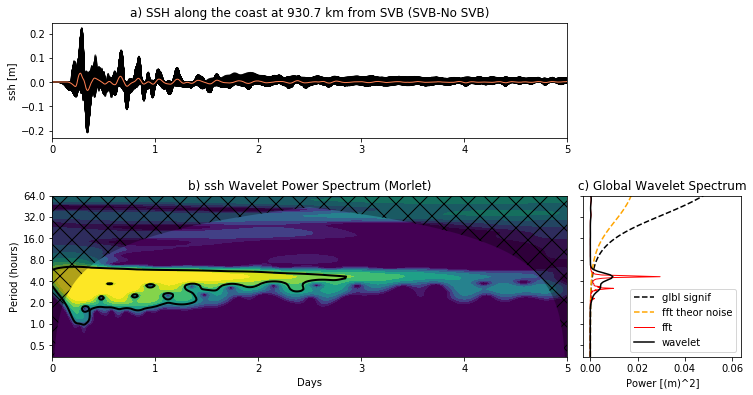

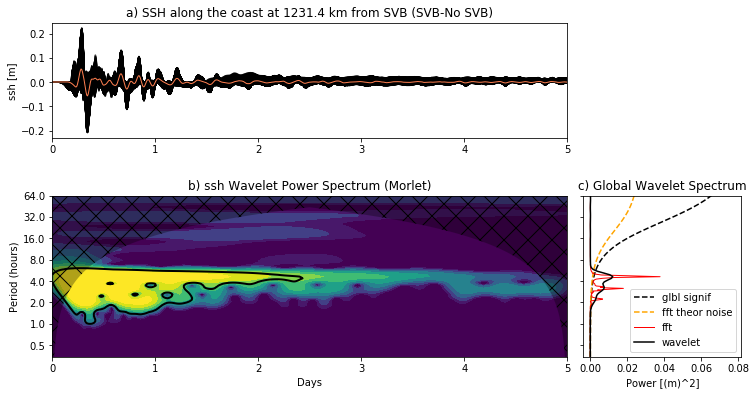

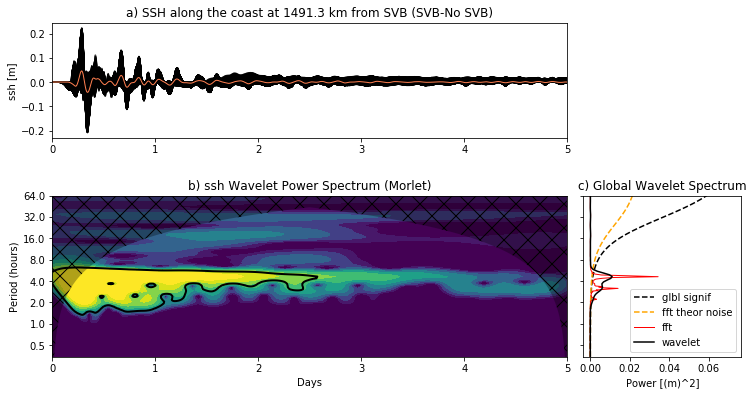

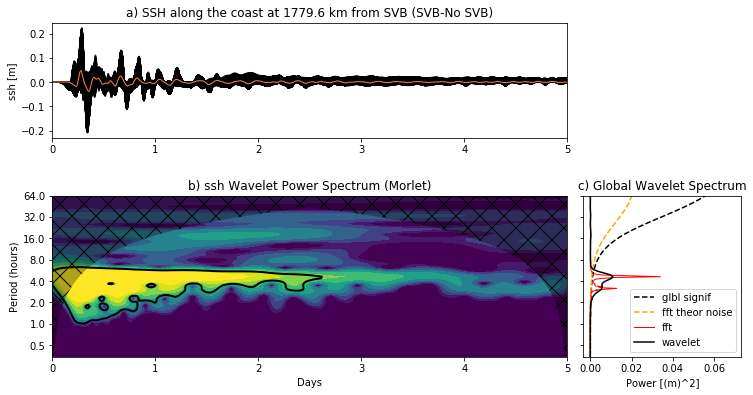

In [28]:
dt = 0.166667  # in hours
indices = [0,50,100,150,200,250,300,350,400,450,500]
dat = (SVB.curtain_data.data-noSVB.curtain_data.data)*100
X = SVB.X[:]
t = SVB.T[:]/3600

label = 'ssh'
units = 'm'

for kk in indices:
    title = 'SSH along the coast at %1.1f km from SVB (SVB-No SVB)' %X[kk]

    dat_notrend = dat[:,kk] - np.nanmean(dat[:,kk])
    std = np.std(dat_notrend)
    var = std**2
    dat_norm = dat_notrend / std # Normalized dataset
    N = len(dat_norm)
        
    mother = wavelet.Morlet(6) 
    s0 = 2 * dt  # Starting scale, in this case 2 * 0.16667 hr = 0.33334 hr = 20 min
    dj = 1 / 12  # Twelve sub-octaves per octaves
    J = 10 / dj  # Eleven powers of two with dj sub-octaves
    alpha, _, _ = wavelet.ar1(dat[:,kk])  # Lag-1 autocorrelation for red noise
    
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                          mother)
    iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
        
    power = (np.abs(wave)) ** 2
    fft_power = np.abs(fft) ** 2
    period = 1 / freqs
        
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                             significance_level=0.95,
                                             wavelet=mother)
    sig95 = np.ones([1, N]) * signif[:, None]
    sig95 = power / sig95

    glbl_power = power.mean(axis=1)
    dof = N - scales  # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                            significance_level=0.95, dof=dof,
                                            wavelet=mother)
        
    ## PLOT
    # Prepare the figure
    plt.close('all')
    plt.ioff()
    figprops = dict(figsize=(11, 8), dpi=72)
    fig = plt.figure(**figprops)

    # First sub-plot, the original time series anomaly and inverse wavelet
    # transform.
    ax = plt.axes([0.1, 0.75, 0.65, 0.2])
    ax.plot(t/(24), dat, 'k', linewidth=1.5, alpha=0.7)
    ax.plot(t/(24), iwave, '-', linewidth=1, color='coral', alpha=1)
    ax.set_title('a) {}'.format(title))
    ax.set_ylabel(r'{} [{}]'.format(label, units))

    # Second sub-plot, the normalized wavelet power spectrum and significance
    # level contour lines and cone of influece hatched area. Note that period
    # scale is logarithmic.
    bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
    bx.contourf(t/(24), np.log2(period), np.log2(power), np.log2(levels),
                extend='both', cmap=plt.cm.viridis)
    extent = [t.min(), t.max(), 0, max(period)]
    bx.contour(t/(24), np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
               extent=extent)
    bx.fill(np.concatenate([t/(24), t[-1:]/(24) + dt/(24), t[-1:]/(24) + dt/(24),
                               t[:1]/(24) - dt/(24), t[:1]/(24) - dt/(24)]),
            np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                            np.log2(period[-1:]), [1e-9]]),
            'k', alpha=0.3, hatch='x')
    bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
    bx.set_ylabel('Period (hours)')
    #
    Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                               np.ceil(np.log2(period.max())))
    bx.set_yticks(np.log2(Yticks))
    bx.set_yticklabels(Yticks)
    bx.set_xlabel('Days')
    bx.set_xlim([0,5])
    # Third sub-plot, the global wavelet and Fourier power spectra and theoretical
    # noise spectra. Note that period scale is logarithmic.
    cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
    cx.plot(glbl_signif, np.log2(period), 'k--', label='glbl signif')
    cx.plot(var * fft_theor, np.log2(period), '--', color='orange',label='fft theor noise')
    cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='red', label='fft',
            linewidth=1.)
    cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5, label = 'wavelet')
    cx.set_title('c) Global Wavelet Spectrum')
    cx.set_xlabel(r'Power [({})^2]'.format(units))
    cx.set_yticks(np.log2(Yticks))
    cx.set_yticklabels(Yticks)
   #cx.set_ylim(np.log2([period.min(), period.max()]))
    cx.set_ylim(np.log2([period.min(), 64]))
    cx.legend()
    plt.setp(cx.get_yticklabels(), visible=False)
  
    plt.show()

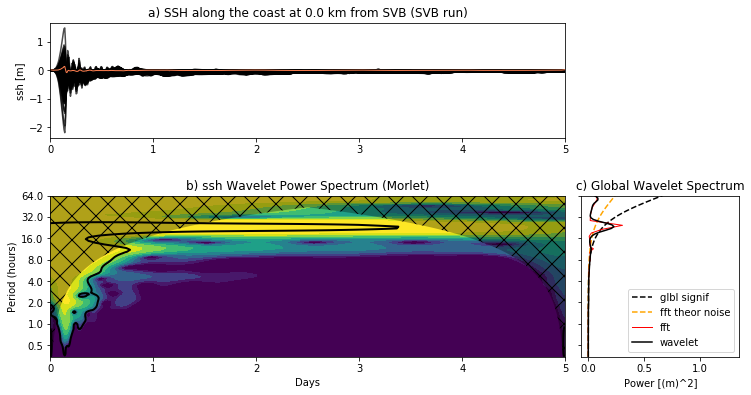

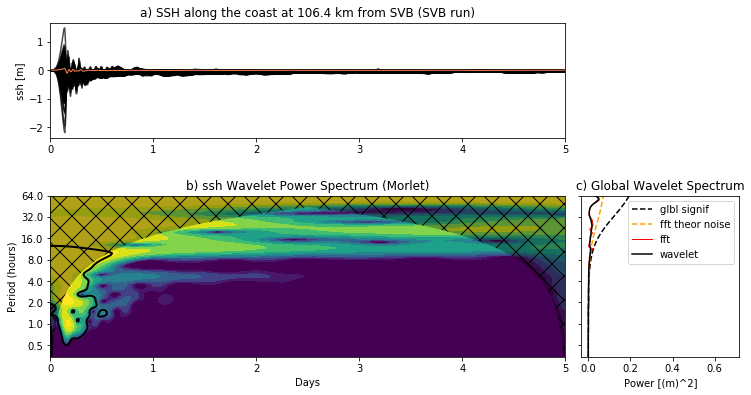

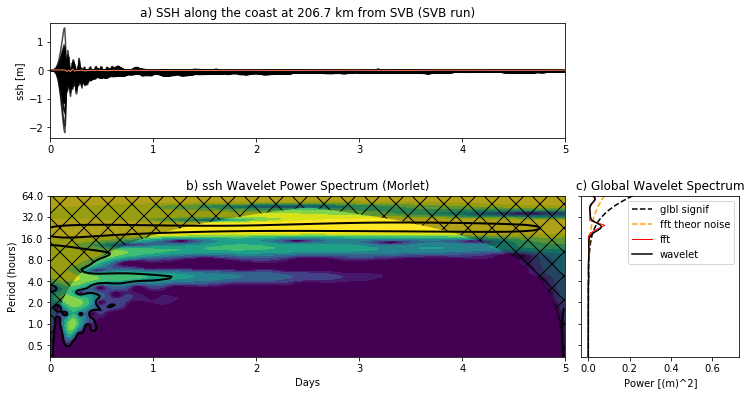

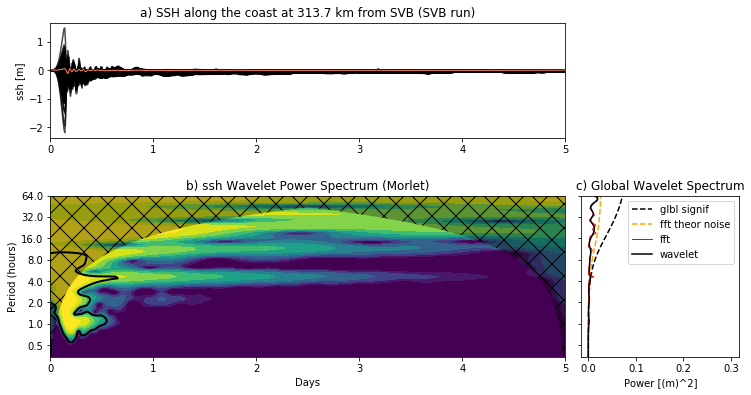

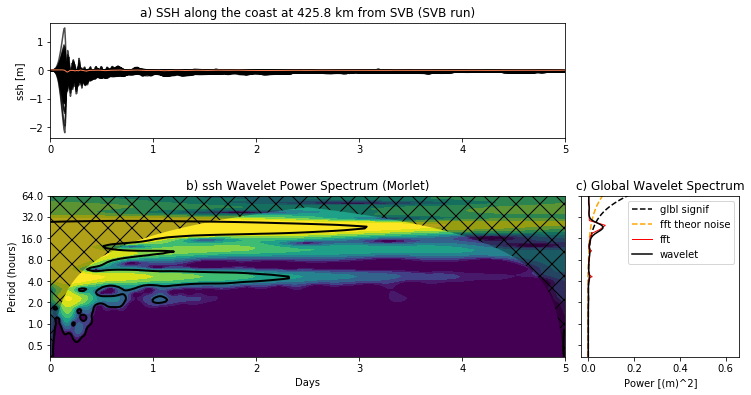

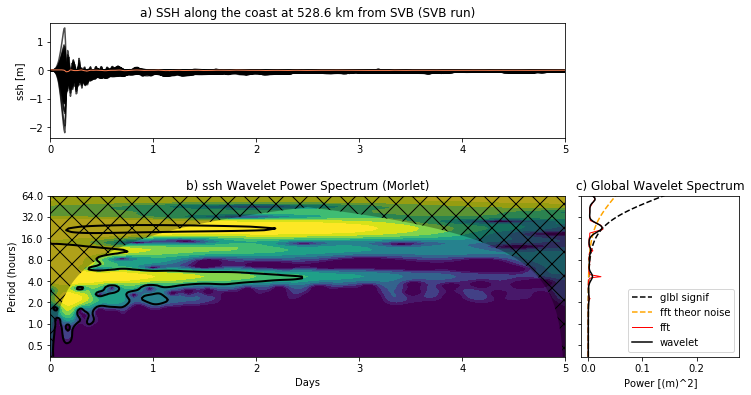

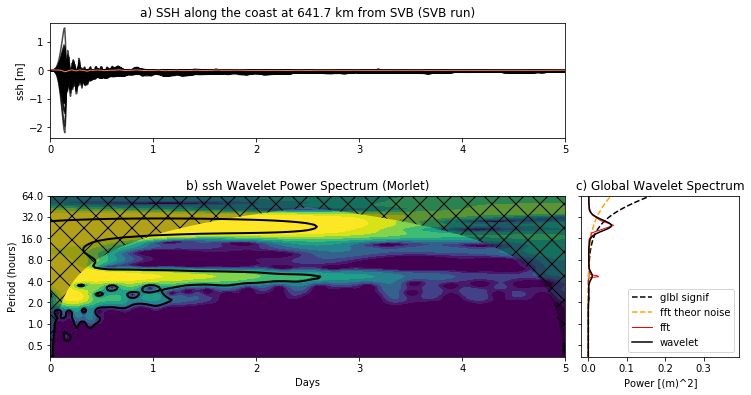

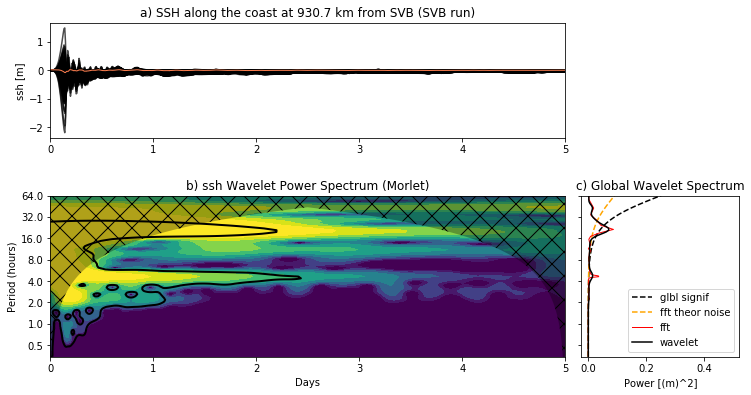

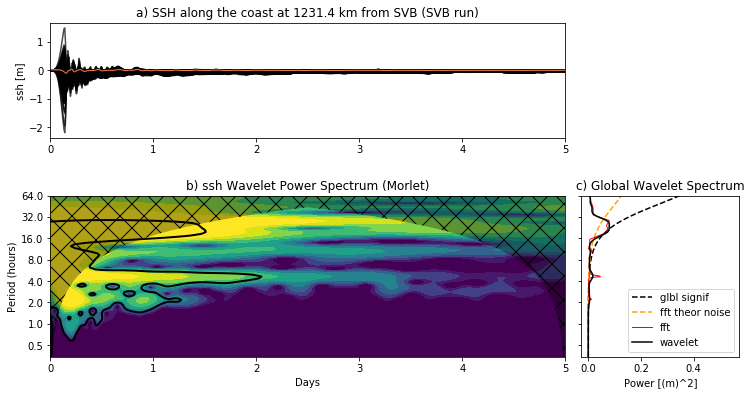

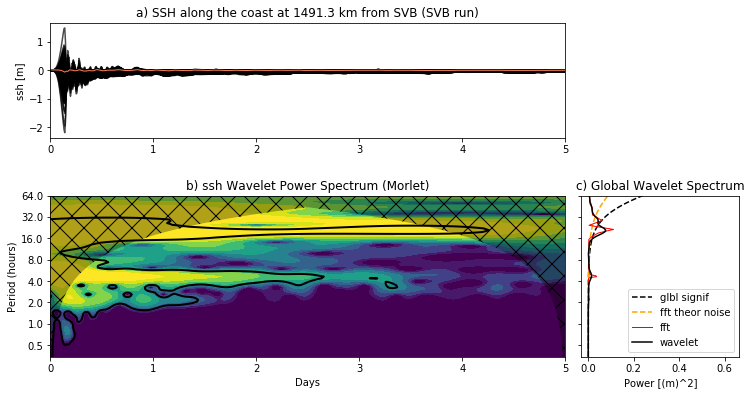

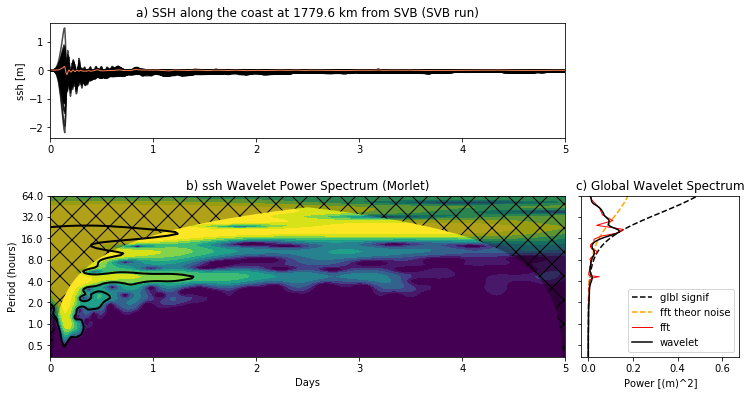

In [29]:
dt = 0.166667  # in hours
indices = [0,50,100,150,200,250,300,350,400,450,500]
dat = (SVB.curtain_data.data)*100
X = SVB.X[:]
t = SVB.T[:]/3600

label = 'ssh'
units = 'm'

for kk in indices:
    title = 'SSH along the coast at %1.1f km from SVB (SVB run)' %X[kk]

    dat_notrend = dat[:,kk] - np.nanmean(dat[:,kk])
    std = np.std(dat_notrend)
    var = std**2
    dat_norm = dat_notrend / std # Normalized dataset
    N = len(dat_norm)
        
    mother = wavelet.Morlet(6) 
    s0 = 2 * dt  # Starting scale, in this case 2 * 0.16667 hr = 0.33334 hr = 20 min
    dj = 1 / 12  # Twelve sub-octaves per octaves
    J = 10 / dj  # Eleven powers of two with dj sub-octaves
    alpha, _, _ = wavelet.ar1(dat[:,kk])  # Lag-1 autocorrelation for red noise
    
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                          mother)
    iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
        
    power = (np.abs(wave)) ** 2
    fft_power = np.abs(fft) ** 2
    period = 1 / freqs
        
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                             significance_level=0.95,
                                             wavelet=mother)
    sig95 = np.ones([1, N]) * signif[:, None]
    sig95 = power / sig95

    glbl_power = power.mean(axis=1)
    dof = N - scales  # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                            significance_level=0.95, dof=dof,
                                            wavelet=mother)
        
    ## PLOT
    # Prepare the figure
    plt.close('all')
    plt.ioff()
    figprops = dict(figsize=(11, 8), dpi=72)
    fig = plt.figure(**figprops)

    # First sub-plot, the original time series anomaly and inverse wavelet
    # transform.
    ax = plt.axes([0.1, 0.75, 0.65, 0.2])
    ax.plot(t/(24), dat, 'k', linewidth=1.5, alpha=0.7)
    ax.plot(t/(24), iwave, '-', linewidth=1, color='coral', alpha=1)
    ax.set_title('a) {}'.format(title))
    ax.set_ylabel(r'{} [{}]'.format(label, units))

    # Second sub-plot, the normalized wavelet power spectrum and significance
    # level contour lines and cone of influece hatched area. Note that period
    # scale is logarithmic.
    bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
    bx.contourf(t/(24), np.log2(period), np.log2(power), np.log2(levels),
                extend='both', cmap=plt.cm.viridis)
    extent = [t.min(), t.max(), 0, max(period)]
    bx.contour(t/(24), np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
               extent=extent)
    bx.fill(np.concatenate([t/(24), t[-1:]/(24) + dt/(24), t[-1:]/(24) + dt/(24),
                               t[:1]/(24) - dt/(24), t[:1]/(24) - dt/(24)]),
            np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                            np.log2(period[-1:]), [1e-9]]),
            'k', alpha=0.3, hatch='x')
    bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
    bx.set_ylabel('Period (hours)')
    #
    Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                               np.ceil(np.log2(period.max())))
    bx.set_yticks(np.log2(Yticks))
    bx.set_yticklabels(Yticks)
    bx.set_xlabel('Days')
    bx.set_xlim([0,5])
    # Third sub-plot, the global wavelet and Fourier power spectra and theoretical
    # noise spectra. Note that period scale is logarithmic.
    cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
    cx.plot(glbl_signif, np.log2(period), 'k--', label='glbl signif')
    cx.plot(var * fft_theor, np.log2(period), '--', color='orange',label='fft theor noise')
    cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='red', label='fft',
            linewidth=1.)
    cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5, label = 'wavelet')
    cx.set_title('c) Global Wavelet Spectrum')
    cx.set_xlabel(r'Power [({})^2]'.format(units))
    cx.set_yticks(np.log2(Yticks))
    cx.set_yticklabels(Yticks)
   #cx.set_ylim(np.log2([period.min(), period.max()]))
    cx.set_ylim(np.log2([period.min(), 64]))
    cx.legend()
    plt.setp(cx.get_yticklabels(), visible=False)
  
    plt.show()

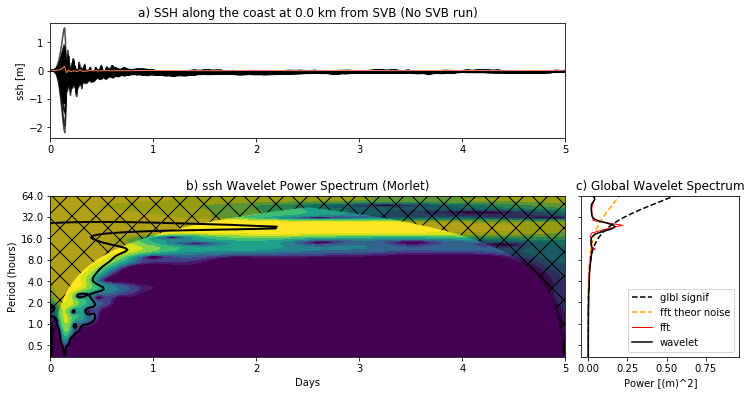

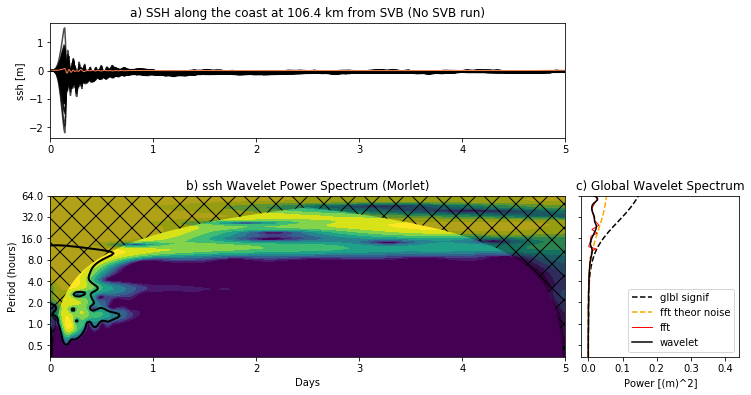

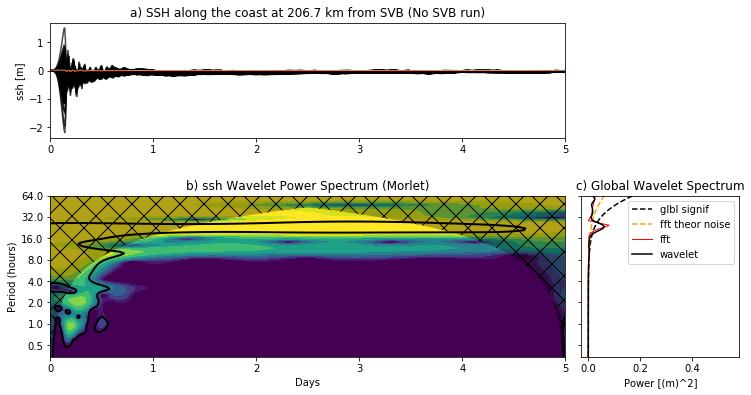

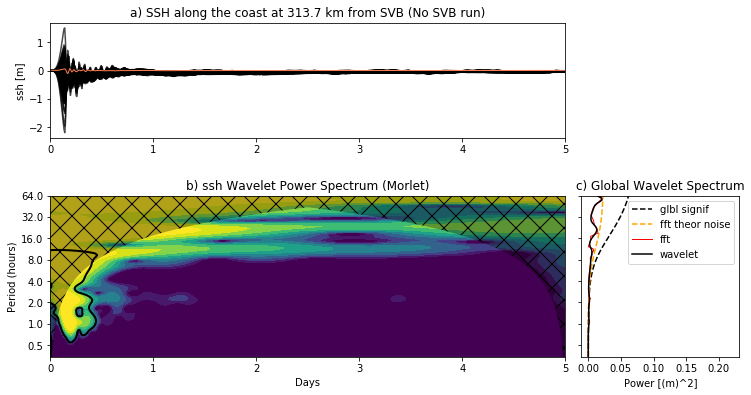

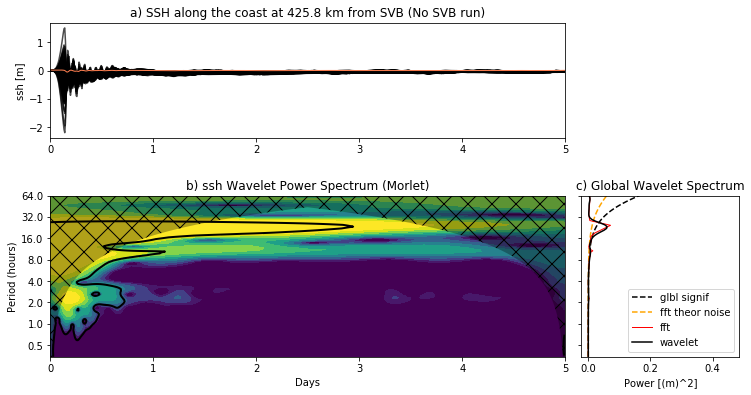

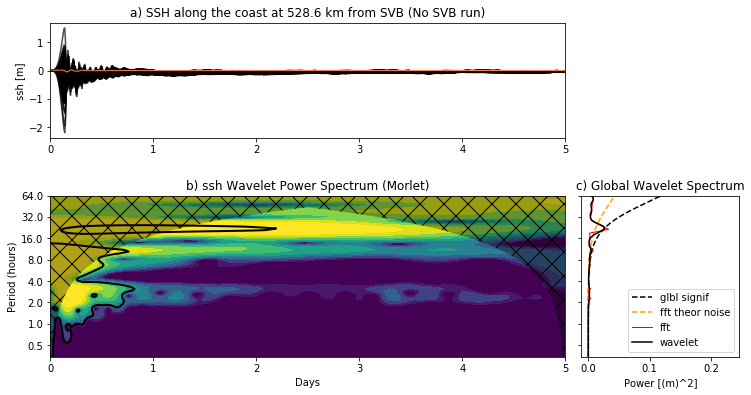

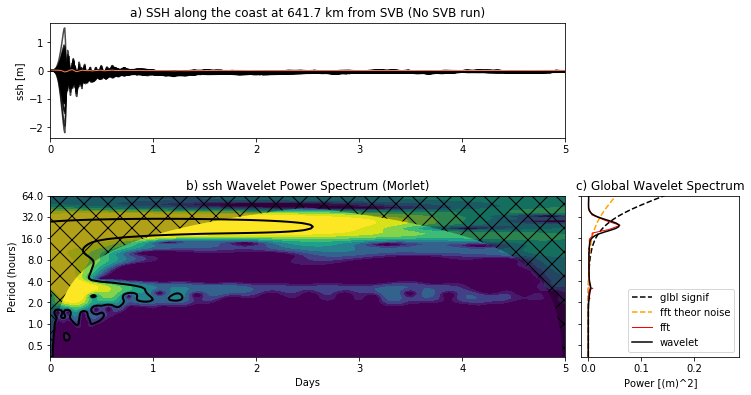

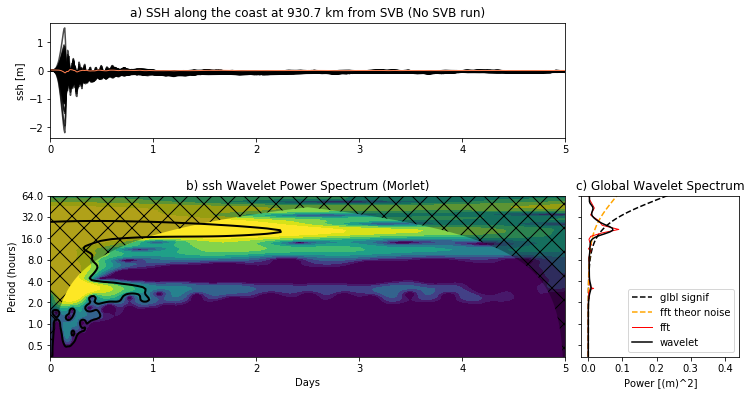

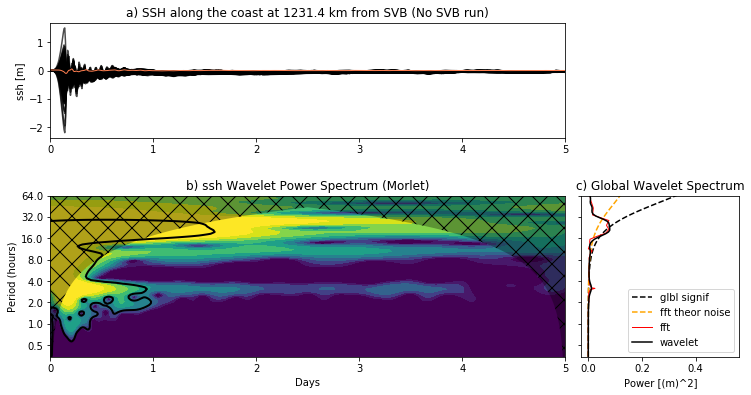

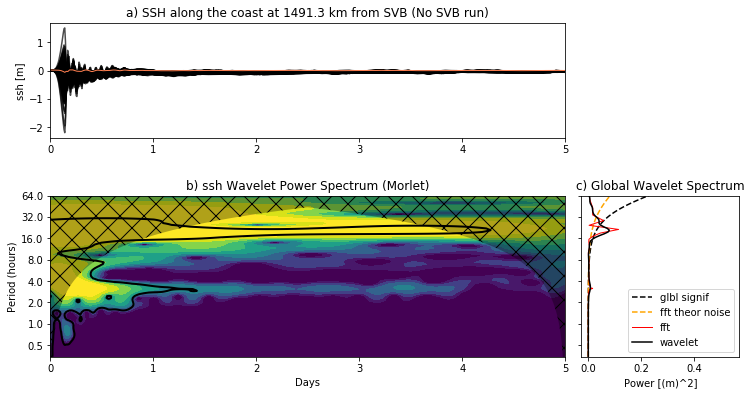

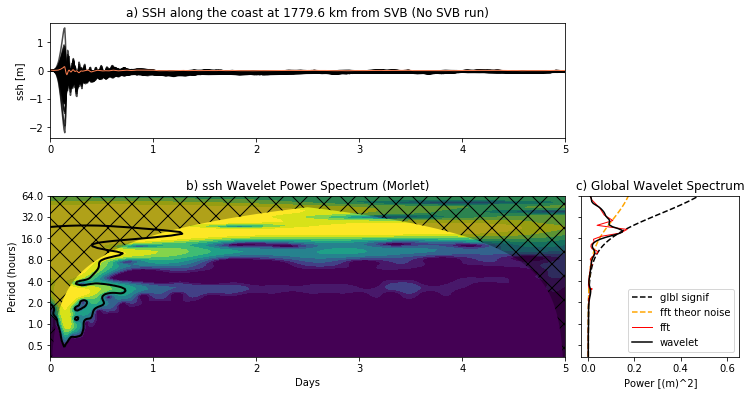

In [30]:
dt = 0.166667  # in hours
indices = [0,50,100,150,200,250,300,350,400,450,500]
dat = (noSVB.curtain_data.data)*100
X = SVB.X[:]
t = SVB.T[:]/3600

label = 'ssh'
units = 'm'

for kk in indices:
    title = 'SSH along the coast at %1.1f km from SVB (No SVB run)' %X[kk]

    dat_notrend = dat[:,kk] - np.nanmean(dat[:,kk])
    std = np.std(dat_notrend)
    var = std**2
    dat_norm = dat_notrend / std # Normalized dataset
    N = len(dat_norm)
        
    mother = wavelet.Morlet(6) 
    s0 = 2 * dt  # Starting scale, in this case 2 * 0.16667 hr = 0.33334 hr = 20 min
    dj = 1 / 12  # Twelve sub-octaves per octaves
    J = 10 / dj  # Eleven powers of two with dj sub-octaves
    alpha, _, _ = wavelet.ar1(dat[:,kk])  # Lag-1 autocorrelation for red noise
    
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                          mother)
    iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
        
    power = (np.abs(wave)) ** 2
    fft_power = np.abs(fft) ** 2
    period = 1 / freqs
        
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                             significance_level=0.95,
                                             wavelet=mother)
    sig95 = np.ones([1, N]) * signif[:, None]
    sig95 = power / sig95

    glbl_power = power.mean(axis=1)
    dof = N - scales  # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                            significance_level=0.95, dof=dof,
                                            wavelet=mother)
        
    ## PLOT
    # Prepare the figure
    plt.close('all')
    plt.ioff()
    figprops = dict(figsize=(11, 8), dpi=72)
    fig = plt.figure(**figprops)

    # First sub-plot, the original time series anomaly and inverse wavelet
    # transform.
    ax = plt.axes([0.1, 0.75, 0.65, 0.2])
    ax.plot(t/(24), dat, 'k', linewidth=1.5, alpha=0.7)
    ax.plot(t/(24), iwave, '-', linewidth=1, color='coral', alpha=1)
    ax.set_title('a) {}'.format(title))
    ax.set_ylabel(r'{} [{}]'.format(label, units))

    # Second sub-plot, the normalized wavelet power spectrum and significance
    # level contour lines and cone of influece hatched area. Note that period
    # scale is logarithmic.
    bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
    bx.contourf(t/(24), np.log2(period), np.log2(power), np.log2(levels),
                extend='both', cmap=plt.cm.viridis)
    extent = [t.min(), t.max(), 0, max(period)]
    bx.contour(t/(24), np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
               extent=extent)
    bx.fill(np.concatenate([t/(24), t[-1:]/(24) + dt/(24), t[-1:]/(24) + dt/(24),
                               t[:1]/(24) - dt/(24), t[:1]/(24) - dt/(24)]),
            np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                            np.log2(period[-1:]), [1e-9]]),
            'k', alpha=0.3, hatch='x')
    bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
    bx.set_ylabel('Period (hours)')
    #
    Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                               np.ceil(np.log2(period.max())))
    bx.set_yticks(np.log2(Yticks))
    bx.set_yticklabels(Yticks)
    bx.set_xlabel('Days')
    bx.set_xlim([0,5])
    # Third sub-plot, the global wavelet and Fourier power spectra and theoretical
    # noise spectra. Note that period scale is logarithmic.
    cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
    cx.plot(glbl_signif, np.log2(period), 'k--', label='glbl signif')
    cx.plot(var * fft_theor, np.log2(period), '--', color='orange',label='fft theor noise')
    cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='red', label='fft',
            linewidth=1.)
    cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5, label = 'wavelet')
    cx.set_title('c) Global Wavelet Spectrum')
    cx.set_xlabel(r'Power [({})^2]'.format(units))
    cx.set_yticks(np.log2(Yticks))
    cx.set_yticklabels(Yticks)
   #cx.set_ylim(np.log2([period.min(), period.max()]))
    cx.set_ylim(np.log2([period.min(), 64]))
    cx.legend()
    plt.setp(cx.get_yticklabels(), visible=False)
  
    plt.show()